# Import library

In [1]:
import os, tempfile, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port
from m2cgen.exporters import export_to_c
# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Dữ liệu từ Bảng 1 & 3 (Private dataset) ---
data_private = {
    'XGB': {
        'Accuracy': 95.43, 'Flash (kB)': 975.17, 'Training time (s)': 0.5728, 'Prediction time (s)': 0.0054,
        'Precision': np.mean([95.25, 91.08, 98.14]), # (95.25 + 91.08 + 98.14) / 3 = 94.82
        'Recall': np.mean([94.78, 90.40, 99.01]),    # (94.78 + 90.40 + 99.01) / 3 = 94.73
        'F1-score': np.mean([95.02, 90.74, 98.57])   # (95.02 + 90.74 + 98.57) / 3 = 94.78
    },
    'RF': {
        'Accuracy': 92.82, 'Flash (kB)': 888.38, 'Training time (s)': 0.4160, 'Prediction time (s)': 0.0061,
        'Precision': np.mean([91.92, 85.39, 98.14]), # 91.82
        'Recall': np.mean([91.44, 86.74, 97.68]),    # 91.95
        'F1-score': np.mean([91.68, 86.06, 97.91])   # 91.88
    },
    'LGBM': {
        'Accuracy': 95.02, 'Flash (kB)': 893.15, 'Training time (s)': 1.6551, 'Prediction time (s)': 0.0520,
        'Precision': np.mean([94.70, 90.28, 98.08]), # 94.36
        'Recall': np.mean([94.35, 89.57, 98.87]),    # 94.26
        'F1-score': np.mean([94.53, 89.92, 98.47])   # 94.31
    },
    'ET': {
        'Accuracy': 91.92, 'Flash (kB)': 936.08, 'Training time (s)': 0.0459, 'Prediction time (s)': 0.0054,
        'Precision': np.mean([89.94, 84.88, 97.82]), # 90.88
        'Recall': np.mean([91.13, 83.03, 97.93]),    # 90.70
        'F1-score': np.mean([90.53, 83.95, 97.88])   # 90.79
    }
}

# --- Dữ liệu từ Bảng 2 & 4 (PVS dataset) ---
data_pvs = {
    'XGB': {
        'Accuracy': 93.21, 'Flash (kB)': 218.83, 'Training time (s)': 0.4319, 'Prediction time (s)': 0.0047,
        'Precision': np.mean([91.96, 84.64, 99.17]), # 91.92
        'Recall': np.mean([89.55, 88.50, 98.70]),    # 92.25
        'F1-score': np.mean([90.74, 86.53, 98.94])   # 92.07
    },
    'RF': {
        'Accuracy': 90.73, 'Flash (kB)': 929.70, 'Training time (s)': 1.4042, 'Prediction time (s)': 0.0114,
        'Precision': np.mean([89.56, 78.87, 98.76]), # 89.06
        'Recall': np.mean([84.50, 85.65, 98.42]),    # 89.52
        'F1-score': np.mean([86.96, 82.12, 98.59])   # 89.22
    },
    'LGBM': {
        'Accuracy': 92.62, 'Flash (kB)': 498.31, 'Training time (s)': 1.8508, 'Prediction time (s)': 0.0133,
        'Precision': np.mean([91.28, 83.01, 99.30]), # 91.20
        'Recall': np.mean([88.30, 87.64, 98.77]),    # 91.57
        'F1-score': np.mean([89.76, 85.26, 99.03])   # 91.35
    },
    'ET': {
        'Accuracy': 86.18, 'Flash (kB)': 975.98, 'Training time (s)': 0.0930, 'Prediction time (s)': 0.0081,
        'Precision': np.mean([85.03, 68.43, 98.64]), # 84.03
        'Recall': np.mean([74.29, 80.98, 98.35]),    # 84.54
        'F1-score': np.mean([79.30, 74.18, 98.49])   # 83.99
    }
}

# --- Định nghĩa mô hình, màu sắc và ký hiệu (marker) ---
models = ['XGB', 'RF', 'LGBM', 'ET']
markers = ['D', 's', 'P', 'X'] # Diamond, Square, Plus (filled), X
colors = ['#d62728', '#2ca02c', '#9467bd', '#1f77b4'] # Các màu sắc khác nhau

# Motobike data (.TXT) and Car data (.CSV)

## Cell 1 - Phân đoạn dữ liệu

In [2]:
# Cell 1 - Phân đoạn dữ liệu mặt đường từ motobike (.TXT) và car (.CSV)

# ============================================================
# PART A – MOTOBIKE DATA (private .TXT dataset @ 100 Hz)
# ============================================================

root_dir_motobike = r"D:\BVHoan\Spiiras Proceedings\data_anh_Kien"

columns_motobike = [
    'Acc_X', 'Acc_Y', 'Acc_Z',
    'Gyr_X', 'Gyr_Y', 'Gyr_Z',
    'Mag_X', 'Mag_Y', 'Mag_Z',
    'Lat', 'Lon', 'Time', 'Date', 'Speed'
]

window_size_motobike = 600   # 600 samples ~ 6s @ 100Hz
stride_motobike      = 300   # 50% overlap

# Các list cửa sổ riêng cho motobike
w_dirt_road_motobike        = []
w_cobblestone_road_motobike = []
w_asphalt_road_motobike     = []

# Hàm phân đoạn file .TXT
def segment_file_motobike(file_path):
    data = pd.read_csv(file_path, names=columns_motobike)
    data['Speed'] = data['Speed'].astype(str).str.replace(';', '', regex=False).astype(float)

    windows = [
        data.iloc[i:i + window_size_motobike]
        for i in range(0, len(data), stride_motobike)
        if i + window_size_motobike <= len(data)
    ]
    return windows

# dirt_road
dir_dirt = os.path.join(root_dir_motobike, "dirt_road")
for filename in os.listdir(dir_dirt):
    if filename.endswith(".TXT"):
        file_path = os.path.join(dir_dirt, filename)
        for w in segment_file_motobike(file_path):
            w_dirt_road_motobike.append(w)

# cobblestone_road
dir_cobb = os.path.join(root_dir_motobike, "cobblestone_road")
for filename in os.listdir(dir_cobb):
    if filename.endswith(".TXT"):
        file_path = os.path.join(dir_cobb, filename)
        for w in segment_file_motobike(file_path):
            w_cobblestone_road_motobike.append(w)

# asphalt_road
dir_asph = os.path.join(root_dir_motobike, "asphalt_road")
for filename in os.listdir(dir_asph):
    if filename.endswith(".TXT"):
        file_path = os.path.join(dir_asph, filename)
        for w in segment_file_motobike(file_path):
            w_asphalt_road_motobike.append(w)

print("Motobike windows:")
print("  w_dirt_road_motobike        =", len(w_dirt_road_motobike))
print("  w_cobblestone_road_motobike =", len(w_cobblestone_road_motobike))
print("  w_asphalt_road_motobike     =", len(w_asphalt_road_motobike))
print("  Total motobike windows      =", len(w_dirt_road_motobike) + len(w_cobblestone_road_motobike) + len(w_asphalt_road_motobike))

# ============================================================
# PART B – CAR DATA (data.csv @ 50 Hz)
# ============================================================

csv_path_car = r"D:\BVHoan\Spiiras Proceedings\data_thay_Cong\data.csv"

df_car = pd.read_csv(csv_path_car)

# Chuẩn hoá cột
df_car = df_car.rename(columns={
    'Ax': 'Acc_X',
    'Ay': 'Acc_Y',
    'Az': 'Acc_Z',
    'Gx': 'Gyr_X',
    'Gy': 'Gyr_Y',
    'Gz': 'Gyr_Z',
    'Mx': 'Mag_X',
    'My': 'Mag_Y',
    'Mz': 'Mag_Z',
    'Speed': 'Speed',
    'ROADSURFACE': 'Label'
})

# Bỏ -1 (dừng xe)
df_car = df_car[df_car['Label'] != -1].reset_index(drop=True)

window_size_car = 300   # 6s @ 50Hz
stride_car      = 150

# Hàm phân đoạn car
def segment_df_car(data):
    windows = [
        data.iloc[i:i + window_size_car]
        for i in range(0, len(data), stride_car)
        if i + window_size_car <= len(data)
    ]
    return windows

# Tách theo lớp
df_dirt_car = df_car[df_car['Label'] == 0].reset_index(drop=True)
df_cobb_car = df_car[df_car['Label'] == 1].reset_index(drop=True)
df_asph_car = df_car[df_car['Label'] == 2].reset_index(drop=True)

# Các list cửa sổ riêng cho car
w_dirt_road_car        = segment_df_car(df_dirt_car)
w_cobblestone_road_car = segment_df_car(df_cobb_car)
w_asphalt_road_car     = segment_df_car(df_asph_car)

print("\nCar windows:")
print("  w_dirt_road_car        =", len(w_dirt_road_car))
print("  w_cobblestone_road_car =", len(w_cobblestone_road_car))
print("  w_asphalt_road_car     =", len(w_asphalt_road_car))
print("  Total car windows      =", 
      len(w_dirt_road_car) + len(w_cobblestone_road_car) + len(w_asphalt_road_car))

print("\nOverall windows:")
print("  w_dirt_road        =", len(w_dirt_road_motobike) + len(w_dirt_road_car))
print("  w_cobblestone_road =", len(w_cobblestone_road_motobike) + len(w_cobblestone_road_car))
print("  w_asphalt_road     =", len(w_asphalt_road_motobike) + len(w_asphalt_road_car))
print("  Total windows      =", len(w_dirt_road_motobike) + len(w_cobblestone_road_motobike) + len(w_asphalt_road_motobike) + len(w_dirt_road_car) + len(w_cobblestone_road_car) + len(w_asphalt_road_car))


Motobike windows:
  w_dirt_road_motobike        = 1280
  w_cobblestone_road_motobike = 166
  w_asphalt_road_motobike     = 2301
  Total motobike windows      = 3747

Car windows:
  w_dirt_road_car        = 1978
  w_cobblestone_road_car = 1991
  w_asphalt_road_car     = 1323
  Total car windows      = 5292

Overall windows:
  w_dirt_road        = 3258
  w_cobblestone_road = 2157
  w_asphalt_road     = 3624
  Total windows      = 9039


In [3]:
# ============================================================
# Tính SỐ LƯỢNG MẪU + THỜI GIAN của motobike, car, và overall
# ============================================================

# =====================
# A. MOTOBIKE (.TXT, 100 Hz)
# =====================

# Số cửa sổ
motobike_windows = (
    len(w_dirt_road_motobike)
    + len(w_cobblestone_road_motobike)
    + len(w_asphalt_road_motobike)
)

# Số mẫu
motobike_samples = 0
for w in w_dirt_road_motobike:
    motobike_samples += len(w)
for w in w_cobblestone_road_motobike:
    motobike_samples += len(w)
for w in w_asphalt_road_motobike:
    motobike_samples += len(w)

# Thời gian (giây) – 100 Hz
motobike_time_seconds = motobike_samples / 100.0

# =====================
# B. CAR (.CSV, 50 Hz)
# =====================

car_windows = (
    len(w_dirt_road_car)
    + len(w_cobblestone_road_car)
    + len(w_asphalt_road_car)
)

car_samples = 0
for w in w_dirt_road_car:
    car_samples += len(w)
for w in w_cobblestone_road_car:
    car_samples += len(w)
for w in w_asphalt_road_car:
    car_samples += len(w)

# Thời gian (giây) – 50 Hz
car_time_seconds = car_samples / 50.0

# =====================
# C. OVERALL (motobike + car)
# =====================

overall_windows = motobike_windows + car_windows
overall_samples = motobike_samples + car_samples

# thời gian theo từng nguồn, không trộn Hz
overall_time_seconds = motobike_time_seconds + car_time_seconds

# =====================
# In kết quả
# =====================

print("\n==================== MOTOBIKE (.TXT – 100 Hz) ====================")
print("Windows:", motobike_windows)
print("Samples:", motobike_samples)
print("Duration:", f"{motobike_time_seconds:.2f} seconds " f"({motobike_time_seconds/60:.2f} minutes, " f"{motobike_time_seconds/3600:.2f} hours)")

print("\n==================== CAR (.CSV – 50 Hz) ====================")
print("Windows:", car_windows)
print("Samples:", car_samples)
print("Duration:", f"{car_time_seconds:.2f} seconds " f"({car_time_seconds/60:.2f} minutes, " f"{car_time_seconds/3600:.2f} hours)")

print("\n==================== OVERALL ====================")
print("Windows:", overall_windows)
print("Samples:", overall_samples)
print("Duration:", f"{overall_time_seconds:.2f} seconds " f"({overall_time_seconds/60:.2f} minutes, " f"{overall_time_seconds/3600:.2f} hours)")



==================== MOTOBIKE (.TXT – 100 Hz) ====================
Windows: 3747
Samples: 2248200
Duration: 22482.00 seconds (374.70 minutes, 6.25 hours)

==================== CAR (.CSV – 50 Hz) ====================
Windows: 5292
Samples: 1587600
Duration: 31752.00 seconds (529.20 minutes, 8.82 hours)

==================== OVERALL ====================
Windows: 9039
Samples: 3835800
Duration: 54234.00 seconds (903.90 minutes, 15.06 hours)


## Cell 2 - Gộp dữ liệu từ cả 2 nguồn: motobike + car

In [3]:
# Cell 2 - Gộp dữ liệu từ cả 2 nguồn: motobike + car

all_data = []
all_labels = []
raw_data_all = []

# ============================================================
# Lớp 0 – Dirt road
# ============================================================

# motobike
for df in w_dirt_road_motobike:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(0)

# car
for df in w_dirt_road_car:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(0)

# ============================================================
# Lớp 1 – Cobblestone road
# ============================================================

# motobike
for df in w_cobblestone_road_motobike:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(1)

# car
for df in w_cobblestone_road_car:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(1)

# ============================================================
# Lớp 2 – Asphalt road
# ============================================================

# motobike
for df in w_asphalt_road_motobike:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(2)

# car
for df in w_asphalt_road_car:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(2)

# ============================================================
# Chuyển nhãn sang NumPy array
# ============================================================

labels_all = np.array(all_labels)

print("Tổng số cửa sổ gộp:", len(all_data))
print("labels_all shape:", labels_all.shape)
print("Số cửa sổ theo lớp (0,1,2):", np.bincount(labels_all))


Tổng số cửa sổ gộp: 9039
labels_all shape: (9039,)
Số cửa sổ theo lớp (0,1,2): [3258 2157 3624]


## Cell 3 - Trích xuất đặc trưng

In [4]:
# Cell 3 - Trích xuất đặc trưng

def featuresFromBuffer(at):
    feat = np.zeros(80, dtype=np.float32)

    ax = np.array(at['Acc_X'],  dtype=np.float32)
    ay = np.array(at['Acc_Y'],  dtype=np.float32)
    az = np.array(at['Acc_Z'],  dtype=np.float32)
    gx = np.array(at['Gyr_X'],  dtype=np.float32)
    gy = np.array(at['Gyr_Y'],  dtype=np.float32)
    gz = np.array(at['Gyr_Z'],  dtype=np.float32)
    sp = np.array(at['Speed'],  dtype=np.float32)

    feat[0:7] = [np.mean(i) for i in [ax, ay, az, gx, gy, gz, sp]]
    feat[7:14] = [np.std(i) for i in [ax, ay, az, gx, gy, gz, sp]]
    feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az, gx, gy, gz]]
    feat[20:26] = [np.max(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[26:32] = [np.min(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[38:44] = [np.median(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax, ay, az, gx, gy, gz]]
    feat[50:56] = [skew(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[56:62] = [kurtosis(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax, ay, az, gx, gy, gz]]
    feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax, ay, az, gx, gy, gz]]
    feat[74:80] = [acf(i, nlags=1)[1] for i in [ax, ay, az, gx, gy, gz]]
    
    return feat

# Trích xuất đặc trưng cho toàn bộ dữ liệu
features_all = np.array([featuresFromBuffer(win) for win in raw_data_all], dtype=np.float32)

print("features_all shape:", features_all.shape)


features_all shape: (9039, 80)


## 1 - Extreme Gradient Boosting (XGBoost) Classifier

### Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

In [5]:
# Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

param_grid = {
    'n_estimators': range(1, 51),
    'max_depth': range(1, 11)
}

vanilla_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---\n")

grid_search_final = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=vanilla_cv,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search_final.fit(features_all, labels_all)

cv_results = []
best_score = -1
best_model  = None
best_params = None
best_size   = None
model_file_path = "micromlgen_private_XGB.h"

for i, params in enumerate(grid_search_final.cv_results_['params']):
    print(f"Checking params {params} ({i+1}/{len(grid_search_final.cv_results_['params'])})...")
    clf = XGBClassifier(**params, random_state=42)
    clf.fit(features_all, labels_all)

    temp_file_path = None
    size_mb = None
    header_tmp = 'micromlgen_XGB_tmp.h'
    error_msg = ""
    try:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False, encoding='utf-8') as tmp:
            temp_file_path = tmp.name
            pass
        c_cpp_code = port(clf, tmp_file=temp_file_path)
        with open(header_tmp, 'w') as f:
            f.write(c_cpp_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024*1024)
        error_msg = ""
    except Exception as e:
        error_msg = str(e)
    finally:
        if temp_file_path and os.path.exists(temp_file_path):
            os.remove(temp_file_path)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)

    # Lưu lại tất cả các trường hợp, kể cả lỗi
    score = grid_search_final.cv_results_['mean_test_score'][i]
    cv_results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'score': score,
        'ModelSize': size_mb,
        'status': ('ok' if (size_mb is not None and size_mb <= 1.0 and not error_msg) else 'oversize' if (size_mb is not None) else f'error: {error_msg}')
    })

    # Chỉ update mô hình tốt nhất nếu hợp lệ
    if size_mb is not None and size_mb <= 1.0 and score > best_score and not error_msg:
        best_score = score
        best_model = clf
        best_params = params
        best_size = size_mb
        # Lưu best model header ra file chính thức
        with open(model_file_path, 'w') as f:
            f.write(c_cpp_code)
        print(f"  => New BEST (Accuracy={score:.4f}, size={size_mb:.3f} MB), saved to '{model_file_path}'")

print("\n===== SUMMARY =====")
if best_model is not None:
    print(f"Best Parameters: {best_params}")
    print(f"Best CV Accuracy: {best_score*100:.2f}%")
    print(f"Model header size: {best_size:.3f} MB (saved to {model_file_path})")
else:
    print("Không tìm thấy cấu hình nào đạt yêu cầu về kích thước (< 1 MB).")

df_cv = pd.DataFrame(cv_results)
df_cv.to_csv('search_results_XGB.csv', index=False)
print("Chi tiết các cấu hình đã lưu vào search_results_XGB.csv")



--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---

Checking params {'max_depth': 1, 'n_estimators': 1} (1/500)...
  => New BEST (Accuracy=0.6392, size=0.002 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 2} (2/500)...
  => New BEST (Accuracy=0.7702, size=0.003 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 3} (3/500)...
  => New BEST (Accuracy=0.7846, size=0.003 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 4} (4/500)...
  => New BEST (Accuracy=0.8032, size=0.004 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 5} (5/500)...
  => New BEST (Accuracy=0.8300, size=0.005 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 6} (6/500)...
  => New BEST (Accuracy=0.8447, size=0.006 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators'

### Cell 5 - Nested cross-validation

In [6]:
# Cell 5 - Nested cross-validation (chỉ dùng các cấu hình deployable từ search_results_XGB.csv)

# ============================================================
# Đọc kết quả vanilla CV + kiểm tra kích thước model
# ============================================================
search_results_path = 'search_results_XGB.csv'  # file do Cell vanilla CV tạo ra
df_search = pd.read_csv(search_results_path)

# Lọc các cấu hình thỏa điều kiện deployable: status == "ok"
df_ok = df_search[df_search['status'] == 'ok'].copy()

if df_ok.empty:
    raise RuntimeError(
        "Không có cấu hình nào có status='ok' trong search_results_XGB.csv."
        "Hãy kiểm tra lại Cell vanilla CV + memory check."
    )

# Tạo danh sách cấu hình hợp lệ cho GridSearchCV
param_grid_restricted = [
    {
        'n_estimators': [int(ne)],
        'max_depth':   [int(md)]
    }
    for ne, md in zip(df_ok['n_estimators'], df_ok['max_depth'])
]

print(f"Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: {len(param_grid_restricted)}")

# ============================================================
# Nested CV với param_grid đã bị ràng buộc bởi kích thước model
# ============================================================

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_scores_acc = []
all_y_true = []
all_y_pred = []
all_test_indices = []

print("\n--- STARTING NESTED CROSS-VALIDATION (DEPLOYABLE MODELS ONLY) ---\n")

outer_fold = 1
for train_idx, test_idx in outer_cv.split(features_all, labels_all):
    print(f"📦 OUTER FOLD {outer_fold}:")

    X_train, X_test = features_all[train_idx], features_all[test_idx]
    y_train, y_test = labels_all[train_idx], labels_all[test_idx]

    print(f"  - Training data size: {len(X_train)}")
    print(f"  - Testing  data size: {len(X_test)}\n")

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=XGBClassifier(random_state=42),
        param_grid=param_grid_restricted,   # 🔒 chỉ các cấu hình size <= 1 MB
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    print(f"  🔍 Starting parameter tuning in INNER CV (10-fold)...")
    print(f"  - Number of candidate configs (deployable): {len(param_grid_restricted)}")

    grid_search.fit(X_train, y_train)

    best_model  = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score  = grid_search.best_score_

    print(f"\n  ✅ INNER CV Completed for OUTER FOLD {outer_fold}:")
    print(f"    - Best Parameters Found: {best_params}")
    print(f"    - Best Inner CV Accuracy: {best_score * 100:.2f}%\n")

    print(f"  🔍 Evaluating best model on OUTER TEST SET for Fold {outer_fold}...")

    y_pred = best_model.predict(X_test)
    acc_outer = accuracy_score(y_test, y_pred)
    
    outer_scores_acc.append(acc_outer)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_test_indices.extend(test_idx)

    print(f"  🔍 OUTER TEST SET: " f"Accuracy = {acc_outer * 100:.2f}%")
    print("-" * 60)
    outer_fold += 1

mean_acc, std_acc = np.mean(outer_scores_acc), np.std(outer_scores_acc)

print("\n--- NESTED CROSS-VALIDATION COMPLETE (DEPLOYABLE HYPER-PARAMETERS) ---")
print(f"Nested CV Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

np.savez_compressed(
    'nested_cv_predictions_XGB.npz',
    y_true=np.array(all_y_true),
    y_pred=np.array(all_y_pred),
    test_indices=np.array(all_test_indices)
)
print("\ny_true, y_pred, and test_indices saved in 'nested_cv_predictions_XGB.npz'.")


Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: 366

--- STARTING NESTED CROSS-VALIDATION (DEPLOYABLE MODELS ONLY) ---

📦 OUTER FOLD 1:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 366



  ✅ INNER CV Completed for OUTER FOLD 1:
    - Best Parameters Found: {'max_depth': 6, 'n_estimators': 42}
    - Best Inner CV Accuracy: 95.03%

  🔍 Evaluating best model on OUTER TEST SET for Fold 1...
  🔍 OUTER TEST SET: Accuracy = 94.91%
------------------------------------------------------------
📦 OUTER FOLD 2:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 366

  ✅ INNER CV Completed for OUTER FOLD 2:
    - Best Parameters Found: {'max_depth': 6, 'n_estimators': 42}
    - Best Inner CV Accuracy: 95.38%

  🔍 Evaluating best model on OUTER TEST SET for Fold 2...
  🔍 OUTER TEST SET: Accuracy = 95.58%
------------------------------------------------------------
📦 OUTER FOLD 3:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 366

  ✅ INNER CV Completed for OUTER FO

### Cell 6 - Ma trận nhầm lẫn


Successfully loaded 9039 true labels and 9039 predicted labels from .npz file.


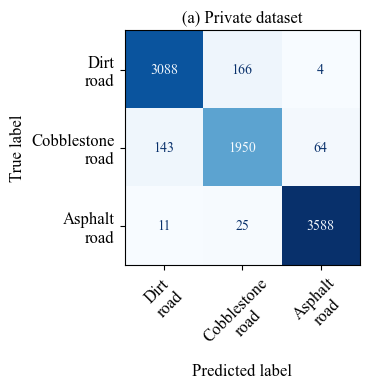

In [7]:
# Cell 6 - Ma trận nhầm lẫn

try:
    loaded_data = np.load('nested_cv_predictions_XGB.npz')
    all_y_true = loaded_data['y_true']
    all_y_pred = loaded_data['y_pred']
    print(f"\nSuccessfully loaded {len(all_y_true)} true labels and {len(all_y_pred)} predicted labels from .npz file.")
except FileNotFoundError:
    print("Saved .npz file not found. Please run the Nested CV process first to generate it.")

class_names = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]

cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
ax.set_title("(a) Private dataset")
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig("confusion_matric_private_dataset.svg", format="svg")
plt.show()


### Cell 7 - Báo cáo phân loại

In [8]:
# Cell 7 - Báo cáo phân loại

print(classification_report(
    all_y_true,
    all_y_pred,
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))


                  precision    recall  f1-score   support

       Dirt road     0.9525    0.9478    0.9502      3258
Cobblestone road     0.9108    0.9040    0.9074      2157
    Asphalt road     0.9814    0.9901    0.9857      3624

        accuracy                         0.9543      9039
       macro avg     0.9482    0.9473    0.9478      9039
    weighted avg     0.9541    0.9543    0.9542      9039



### Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

In [9]:
# Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_XGB = XGBClassifier(n_estimators=41, max_depth=6, random_state=42)
final_clf_XGB.fit(features_all, labels_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_private_XGB.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_XGB, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_private_XGB.h'
📦 Header size: 975.17 KB (0.952 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmpnmetj0hx.json


### Cell 9 - Đo thời gian huấn luyện và dự đoán

In [12]:
# Cell 9 - Đo thời gian huấn luyện và dự đoán

clf = XGBClassifier(n_estimators=41, max_depth=6, random_state=42)

# Đo thời gian huấn luyện trên toàn bộ dữ liệu
start_train = time.perf_counter()
clf.fit(features_all, labels_all)
end_train = time.perf_counter()
train_time = end_train - start_train

# Đo thời gian dự đoán (ví dụ dự đoán toàn bộ dữ liệu)
start_pred = time.perf_counter()
y_pred = clf.predict(features_all)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

print(f"Training time: {train_time:.4f} seconds")
print(f"Prediction time: {pred_time:.4f} seconds")

# Training time: 0.5728 seconds
# Prediction time: 0.0054 seconds


Training time: 0.5907 seconds
Prediction time: 0.0054 seconds


## 2 - Random Forest (RF) Classifier

### Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

In [12]:
# Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

param_grid = {
    'n_estimators': range(1, 51),
    'max_depth': range(1, 21)
}

vanilla_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---\n")

grid_search_final = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=vanilla_cv,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search_final.fit(features_all, labels_all)

cv_results = []
best_score = -1
best_model  = None
best_params = None
best_size   = None
model_file_path = "micromlgen_private_RF.h"

for i, params in enumerate(grid_search_final.cv_results_['params']):
    print(f"Checking params {params} ({i+1}/{len(grid_search_final.cv_results_['params'])})...")
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(features_all, labels_all)

    temp_file_path = None
    size_mb = None
    header_tmp = 'micromlgen_RF_tmp.h'
    error_msg = ""
    try:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False, encoding='utf-8') as tmp:
            temp_file_path = tmp.name
            pass
        c_cpp_code = port(clf, tmp_file=temp_file_path)
        with open(header_tmp, 'w') as f:
            f.write(c_cpp_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024*1024)
        error_msg = ""
    except Exception as e:
        error_msg = str(e)
    finally:
        if temp_file_path and os.path.exists(temp_file_path):
            os.remove(temp_file_path)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)

    # Lưu lại tất cả các trường hợp, kể cả lỗi
    score = grid_search_final.cv_results_['mean_test_score'][i]
    cv_results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'score': score,
        'ModelSize': size_mb,
        'status': ('ok' if (size_mb is not None and size_mb <= 1.0 and not error_msg) else 'oversize' if (size_mb is not None) else f'error: {error_msg}')
    })

    # Chỉ update mô hình tốt nhất nếu hợp lệ
    if size_mb is not None and size_mb <= 1.0 and score > best_score and not error_msg:
        best_score = score
        best_model = clf
        best_params = params
        best_size = size_mb
        # Lưu best model header ra file chính thức
        with open(model_file_path, 'w') as f:
            f.write(c_cpp_code)
        print(f"  => New BEST (Accuracy={score:.4f}, size={size_mb:.3f} MB), saved to '{model_file_path}'")

print("\n===== SUMMARY =====")
if best_model is not None:
    print(f"Best Parameters: {best_params}")
    print(f"Best CV Accuracy: {best_score*100:.2f}%")
    print(f"Model header size: {best_size:.3f} MB (saved to {model_file_path})")
else:
    print("Không tìm thấy cấu hình nào đạt yêu cầu về kích thước (< 1 MB).")

df_cv = pd.DataFrame(cv_results)
df_cv.to_csv('search_results_RF.csv', index=False)
print("Chi tiết các cấu hình đã lưu vào search_results_RF.csv")



--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---



Checking params {'max_depth': 1, 'n_estimators': 1} (1/1000)...
  => New BEST (Accuracy=0.6063, size=0.001 MB), saved to 'micromlgen_private_RF.h'
Checking params {'max_depth': 1, 'n_estimators': 2} (2/1000)...
  => New BEST (Accuracy=0.6070, size=0.001 MB), saved to 'micromlgen_private_RF.h'
Checking params {'max_depth': 1, 'n_estimators': 3} (3/1000)...
Checking params {'max_depth': 1, 'n_estimators': 4} (4/1000)...
Checking params {'max_depth': 1, 'n_estimators': 5} (5/1000)...
  => New BEST (Accuracy=0.6123, size=0.002 MB), saved to 'micromlgen_private_RF.h'
Checking params {'max_depth': 1, 'n_estimators': 6} (6/1000)...
Checking params {'max_depth': 1, 'n_estimators': 7} (7/1000)...
Checking params {'max_depth': 1, 'n_estimators': 8} (8/1000)...
  => New BEST (Accuracy=0.6127, size=0.003 MB), saved to 'micromlgen_private_RF.h'
Checking params {'max_depth': 1, 'n_estimators': 9} (9/1000)...
Checking params {'max_depth': 1, 'n_estimators': 10} (10/1000)...
Checking params {'max_dept

### Cell 5 - Nested cross-validation

In [13]:
# Cell 5 - Nested cross-validation (chỉ dùng các cấu hình deployable từ search_results_RF.csv)

# ============================================================
# Đọc kết quả vanilla CV + kiểm tra kích thước model
# ============================================================
search_results_path = 'search_results_RF.csv'  # file do Cell vanilla CV tạo ra
df_search = pd.read_csv(search_results_path)

# Lọc các cấu hình thỏa điều kiện deployable: status == "ok"
df_ok = df_search[df_search['status'] == 'ok'].copy()

if df_ok.empty:
    raise RuntimeError(
        "Không có cấu hình nào có status='ok' trong search_results_RF.csv."
        "Hãy kiểm tra lại Cell vanilla CV + memory check."
    )

# Tạo danh sách cấu hình hợp lệ cho GridSearchCV
param_grid_restricted = [
    {
        'n_estimators': [int(ne)],
        'max_depth':   [int(md)]
    }
    for ne, md in zip(df_ok['n_estimators'], df_ok['max_depth'])
]

print(f"Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: {len(param_grid_restricted)}")

# ============================================================
# Nested CV với param_grid đã bị ràng buộc bởi kích thước model
# ============================================================

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_scores_acc = []
all_y_true = []
all_y_pred = []
all_test_indices = []

print("\n--- STARTING NESTED CROSS-VALIDATION (DEPLOYABLE MODELS ONLY) ---\n")

outer_fold = 1
for train_idx, test_idx in outer_cv.split(features_all, labels_all):
    print(f"📦 OUTER FOLD {outer_fold}:")

    X_train, X_test = features_all[train_idx], features_all[test_idx]
    y_train, y_test = labels_all[train_idx], labels_all[test_idx]

    print(f"  - Training data size: {len(X_train)}")
    print(f"  - Testing  data size: {len(X_test)}\n")

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid_restricted,   # 🔒 chỉ các cấu hình size <= 1 MB
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    print(f"  🔍 Starting parameter tuning in INNER CV (10-fold)...")
    print(f"  - Number of candidate configs (deployable): {len(param_grid_restricted)}")

    grid_search.fit(X_train, y_train)

    best_model  = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score  = grid_search.best_score_

    print(f"\n  ✅ INNER CV Completed for OUTER FOLD {outer_fold}:")
    print(f"    - Best Parameters Found: {best_params}")
    print(f"    - Best Inner CV Accuracy: {best_score * 100:.2f}%\n")

    print(f"  🔍 Evaluating best model on OUTER TEST SET for Fold {outer_fold}...")

    y_pred = best_model.predict(X_test)
    acc_outer = accuracy_score(y_test, y_pred)

    outer_scores_acc.append(acc_outer)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_test_indices.extend(test_idx)

    print(f"  🔍 OUTER TEST SET: " f"Accuracy = {acc_outer * 100:.2f}%")
    print("-" * 60)
    outer_fold += 1

mean_acc, std_acc = np.mean(outer_scores_acc), np.std(outer_scores_acc)

print("\n--- NESTED CROSS-VALIDATION COMPLETE (DEPLOYABLE HYPER-PARAMETERS) ---")
print(f"Nested CV Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

np.savez_compressed(
    'nested_cv_predictions_RF.npz',
    y_true=np.array(all_y_true),
    y_pred=np.array(all_y_pred),
    test_indices=np.array(all_test_indices)
)
print("\ny_true, y_pred, and test_indices saved in 'nested_cv_predictions_RF.npz'.")


Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: 535

--- STARTING NESTED CROSS-VALIDATION (ROAD SURFACE, DEPLOYABLE MODELS ONLY) ---

📦 OUTER FOLD 1:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 535



  ✅ INNER CV Completed for OUTER FOLD 1:
    - Best Parameters Found: {'max_depth': 12, 'n_estimators': 12}
    - Best Inner CV Accuracy: 92.80%

  🔍 Evaluating best model on OUTER TEST SET for Fold 1...
  🔍 OUTER TEST SET: Accuracy = 93.03%
------------------------------------------------------------
📦 OUTER FOLD 2:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 535

  ✅ INNER CV Completed for OUTER FOLD 2:
    - Best Parameters Found: {'max_depth': 11, 'n_estimators': 16}
    - Best Inner CV Accuracy: 93.02%

  🔍 Evaluating best model on OUTER TEST SET for Fold 2...
  🔍 OUTER TEST SET: Accuracy = 92.70%
------------------------------------------------------------
📦 OUTER FOLD 3:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 535

  ✅ INNER CV Completed for OUTER 

### Cell 6 - Ma trận nhầm lẫn


Successfully loaded 9039 true labels and 9039 predicted labels from .npz file.


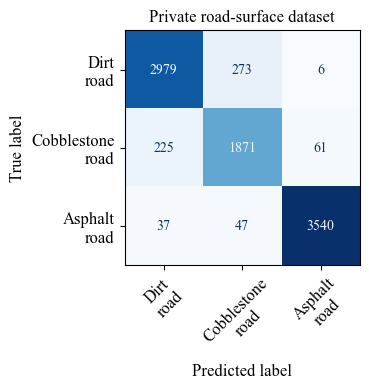

In [14]:
# Cell 6 - Ma trận nhầm lẫn

try:
    loaded_data = np.load('nested_cv_predictions_RF.npz')
    all_y_true = loaded_data['y_true']
    all_y_pred = loaded_data['y_pred']
    print(f"\nSuccessfully loaded {len(all_y_true)} true labels and {len(all_y_pred)} predicted labels from .npz file.")
except FileNotFoundError:
    print("Saved .npz file not found. Please run the Nested CV process first to generate it.")

class_names = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]

cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
ax.set_title("Private road-surface dataset")
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


### Cell 7 - Báo cáo phân loại

In [15]:
# Cell 7 - Báo cáo phân loại

print(classification_report(
    all_y_true,
    all_y_pred,
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))


                  precision    recall  f1-score   support

       Dirt road     0.9192    0.9144    0.9168      3258
Cobblestone road     0.8539    0.8674    0.8606      2157
    Asphalt road     0.9814    0.9768    0.9791      3624

        accuracy                         0.9282      9039
       macro avg     0.9182    0.9195    0.9188      9039
    weighted avg     0.9286    0.9282    0.9284      9039



### Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

In [7]:
# Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(n_estimators=8, max_depth=14, random_state=42)
final_clf_RF.fit(features_all, labels_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_private_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_private_RF.h'
📦 Header size: 888.38 KB (0.868 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmp6vv1wtuc.json


### Cell 9 - Đo thời gian huấn luyện và dự đoán

In [13]:
# Cell 9 - Đo thời gian huấn luyện và dự đoán

clf = RandomForestClassifier(n_estimators=8, max_depth=14, random_state=42)

# Đo thời gian huấn luyện trên toàn bộ dữ liệu
start_train = time.perf_counter()
clf.fit(features_all, labels_all)
end_train = time.perf_counter()
train_time = end_train - start_train

# Đo thời gian dự đoán (ví dụ dự đoán toàn bộ dữ liệu)
start_pred = time.perf_counter()
y_pred = clf.predict(features_all)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# In kết quả
print(f"Training time: {train_time:.4f} seconds")
print(f"Prediction time: {pred_time:.4f} seconds")

# Training time: 0.4160 seconds
# Prediction time: 0.0061 seconds


Training time: 0.4716 seconds
Prediction time: 0.0062 seconds


## 3 - Light Gradient-Boosting (LightGBM) Classifier

### Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

In [18]:
# Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

param_grid = {
    'n_estimators': range(1, 51),
    'max_depth': range(1, 21)
}

vanilla_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---\n")

grid_search_final = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    cv=vanilla_cv,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search_final.fit(features_all, labels_all)

cv_results = []
best_score = -1
best_model  = None
best_params = None
best_size   = None
model_file_path = "m2cgen_private_LGBM.h"

for i, params in enumerate(grid_search_final.cv_results_['params']):
    print(f"Checking params {params} ({i+1}/{len(grid_search_final.cv_results_['params'])})...")
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(features_all, labels_all)
    size_mb = None
    header_tmp = 'm2cgen_LGBM_tmp.h'
    error_msg = ""
    try:
        c_cpp_code = export_to_c(clf)
        with open(header_tmp, 'w') as f:
            f.write(c_cpp_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
        error_msg = ""
    except Exception as e:
        error_msg = str(e)
    finally:
        if os.path.exists(header_tmp):
            os.remove(header_tmp)

    # Lưu lại tất cả các trường hợp, kể cả lỗi
    score = grid_search_final.cv_results_['mean_test_score'][i]
    cv_results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'score': score,
        'ModelSize': size_mb,
        'status': ('ok' if (size_mb is not None and size_mb <= 1.0 and not error_msg) else 'oversize' if (size_mb is not None) else f'error: {error_msg}')
    })

    # Chỉ update mô hình tốt nhất nếu hợp lệ
    if size_mb is not None and size_mb <= 1.0 and score > best_score and not error_msg:
        best_score = score
        best_model = clf
        best_params = params
        best_size = size_mb
        # Lưu best model header ra file chính thức
        with open(model_file_path, 'w') as f:
            f.write(c_cpp_code)
        print(f"  => New BEST (Accuracy={score:.4f}, size={size_mb:.3f} MB), saved to '{model_file_path}'")

print("\n===== SUMMARY =====")
if best_model is not None:
    print(f"Best Parameters: {best_params}")
    print(f"Best CV Accuracy: {best_score*100:.2f}%")
    print(f"Model header size: {best_size:.3f} MB (saved to {model_file_path})")
else:
    print("Không tìm thấy cấu hình nào đạt yêu cầu về kích thước (< 1 MB).")

df_cv = pd.DataFrame(cv_results)
df_cv.to_csv('search_results_LGBM.csv', index=False)
print("Chi tiết các cấu hình đã lưu vào search_results_LGBM.csv")



--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19902
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 80
[LightGBM] [Info] Start training from score -1.020435
[LightGBM] [Info] Start training from score -1.432830
[LightGBM] [Info] Start training from score -0.913970
Checking params {'max_depth': 1, 'n_estimators': 1} (1/1000)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19902
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 80
[LightGBM] [Info] Start training from score -1.020435
[LightGBM] [Info] Start training from score -1.432830
[LightGBM] [Info] Start training from score -0.913970
[LightGBM] [Warning] No further sp

### Cell 5 - Nested cross-validation

In [19]:
# Cell 5 - Nested cross-validation (chỉ dùng các cấu hình deployable từ search_results_LGBM.csv)

# ============================================================
# Đọc kết quả vanilla CV + kiểm tra kích thước model
# ============================================================
search_results_path = 'search_results_LGBM.csv'  # file do Cell vanilla CV tạo ra
df_search = pd.read_csv(search_results_path)

# Lọc các cấu hình thỏa điều kiện deployable: status == "ok"
df_ok = df_search[df_search['status'] == 'ok'].copy()

if df_ok.empty:
    raise RuntimeError(
        "Không có cấu hình nào có status='ok' trong search_results_LGBM.csv."
        "Hãy kiểm tra lại Cell vanilla CV + memory check."
    )

# Tạo danh sách cấu hình hợp lệ cho GridSearchCV
param_grid_restricted = [
    {
        'n_estimators': [int(ne)],
        'max_depth':   [int(md)]
    }
    for ne, md in zip(df_ok['n_estimators'], df_ok['max_depth'])
]

print(f"Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: {len(param_grid_restricted)}")

# ============================================================
# Nested CV với param_grid đã bị ràng buộc bởi kích thước model
# ============================================================

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_scores_acc = []
all_y_true = []
all_y_pred = []
all_test_indices = []

print("\n--- STARTING NESTED CROSS-VALIDATION (DEPLOYABLE MODELS ONLY) ---\n")

outer_fold = 1
for train_idx, test_idx in outer_cv.split(features_all, labels_all):
    print(f"📦 OUTER FOLD {outer_fold}:")

    X_train, X_test = features_all[train_idx], features_all[test_idx]
    y_train, y_test = labels_all[train_idx], labels_all[test_idx]

    print(f"  - Training data size: {len(X_train)}")
    print(f"  - Testing  data size: {len(X_test)}\n")

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=LGBMClassifier(random_state=42),
        param_grid=param_grid_restricted,   # 🔒 chỉ các cấu hình size <= 1 MB
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    print(f"  🔍 Starting parameter tuning in INNER CV (10-fold)...")
    print(f"  - Number of candidate configs (deployable): {len(param_grid_restricted)}")

    grid_search.fit(X_train, y_train)

    best_model  = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score  = grid_search.best_score_

    print(f"\n  ✅ INNER CV Completed for OUTER FOLD {outer_fold}:")
    print(f"    - Best Parameters Found: {best_params}")
    print(f"    - Best Inner CV Accuracy: {best_score * 100:.2f}%\n")

    print(f"  🔍 Evaluating best model on OUTER TEST SET for Fold {outer_fold}...")

    y_pred = best_model.predict(X_test)
    acc_outer = accuracy_score(y_test, y_pred)
    
    outer_scores_acc.append(acc_outer)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_test_indices.extend(test_idx)

    print(f"  🔍 OUTER TEST SET: " f"Accuracy = {acc_outer * 100:.2f}%")
    print("-" * 60)
    outer_fold += 1

mean_acc, std_acc = np.mean(outer_scores_acc), np.std(outer_scores_acc)

print("\n--- NESTED CROSS-VALIDATION COMPLETE (DEPLOYABLE HYPER-PARAMETERS) ---")
print(f"Nested CV Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

np.savez_compressed(
    'nested_cv_predictions_LGBM.npz',
    y_true=np.array(all_y_true),
    y_pred=np.array(all_y_pred),
    test_indices=np.array(all_test_indices)
)
print("\ny_true, y_pred, and test_indices saved in 'nested_cv_predictions_LGBM.npz'.")


Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: 1000

--- STARTING NESTED CROSS-VALIDATION (ROAD SURFACE, DEPLOYABLE MODELS ONLY) ---

📦 OUTER FOLD 1:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19879
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432972
[LightGBM] [Info] Start training from score -0.913835

  ✅ INNER CV Completed for OUTER FOLD 1:
    - Best Parameters Found: {'max_depth': 17, 'n_estimators': 50}
    - Best Inner CV Accuracy: 94.97%

  🔍 Evaluating best model on OUTER TEST SET for Fold 1...
 

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19888
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432972
[LightGBM] [Info] Start training from score -0.913835

  ✅ INNER CV Completed for OUTER FOLD 2:
    - Best Parameters Found: {'max_depth': 17, 'n_estimators': 50}
    - Best Inner CV Accuracy: 95.21%

  🔍 Evaluating best model on OUTER TEST SET for Fold 2...
  🔍 OUTER TEST SET: Accuracy = 94.91%
------------------------------------------------------------
📦 OUTER FOLD 3:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19892
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432972
[LightGBM] [Info] Start training from score -0.913835

  ✅ INNER CV Completed for OUTER FOLD 3:
    - Best Parameters Found: {'max_depth': 19, 'n_estimators': 48}
    - Best Inner CV Accuracy: 95.32%

  🔍 Evaluating best model on OUTER TEST SET for Fold 3...
  🔍 OUTER TEST SET: Accuracy = 96.02%
------------------------------------------------------------
📦 OUTER FOLD 4:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19878
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432972
[LightGBM] [Info] Start training from score -0.913835

  ✅ INNER CV Completed for OUTER FOLD 4:
    - Best Parameters Found: {'max_depth': 16, 'n_estimators': 50}
    - Best Inner CV Accuracy: 95.02%

  🔍 Evaluating best model on OUTER TEST SET for Fold 4...
  🔍 OUTER TEST SET: Accuracy = 94.03%
------------------------------------------------------------
📦 OUTER FOLD 5:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19885
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432972
[LightGBM] [Info] Start training from score -0.913835

  ✅ INNER CV Completed for OUTER FOLD 5:
    - Best Parameters Found: {'max_depth': 15, 'n_estimators': 50}
    - Best Inner CV Accuracy: 95.23%

  🔍 Evaluating best model on OUTER TEST SET for Fold 5...
  🔍 OUTER TEST SET: Accuracy = 94.91%
------------------------------------------------------------
📦 OUTER FOLD 6:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19893
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432457
[LightGBM] [Info] Start training from score -0.914142

  ✅ INNER CV Completed for OUTER FOLD 6:
    - Best Parameters Found: {'max_depth': 16, 'n_estimators': 50}
    - Best Inner CV Accuracy: 95.24%

  🔍 Evaluating best model on OUTER TEST SET for Fold 6...
  🔍 OUTER TEST SET: Accuracy = 94.69%
------------------------------------------------------------
📦 OUTER FOLD 7:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19895
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432457
[LightGBM] [Info] Start training from score -0.914142

  ✅ INNER CV Completed for OUTER FOLD 7:
    - Best Parameters Found: {'max_depth': 15, 'n_estimators': 50}
    - Best Inner CV Accuracy: 95.19%

  🔍 Evaluating best model on OUTER TEST SET for Fold 7...
  🔍 OUTER TEST SET: Accuracy = 95.13%
------------------------------------------------------------
📦 OUTER FOLD 8:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19887
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020491
[LightGBM] [Info] Start training from score -1.432457
[LightGBM] [Info] Start training from score -0.914142

  ✅ INNER CV Completed for OUTER FOLD 8:
    - Best Parameters Found: {'max_depth': 16, 'n_estimators': 50}
    - Best Inner CV Accuracy: 94.94%

  🔍 Evaluating best model on OUTER TEST SET for Fold 8...
  🔍 OUTER TEST SET: Accuracy = 94.69%
------------------------------------------------------------
📦 OUTER FOLD 9:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19885
[LightGBM] [Info] Number of data points in the train set: 8135, number of used features: 80
[LightGBM] [Info] Start training from score -1.020150
[LightGBM] [Info] Start training from score -1.432972
[LightGBM] [Info] Start training from score -0.914142

  ✅ INNER CV Completed for OUTER FOLD 9:
    - Best Parameters Found: {'max_depth': 15, 'n_estimators': 50}
    - Best Inner CV Accuracy: 95.25%

  🔍 Evaluating best model on OUTER TEST SET for Fold 9...
  🔍 OUTER TEST SET: Accuracy = 95.69%
------------------------------------------------------------
📦 OUTER FOLD 10:
  - Training data size: 8136
  - Testing  data size: 903

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 1000


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19889
[LightGBM] [Info] Number of data points in the train set: 8136, number of used features: 80
[LightGBM] [Info] Start training from score -1.020273
[LightGBM] [Info] Start training from score -1.433095
[LightGBM] [Info] Start training from score -0.913958

  ✅ INNER CV Completed for OUTER FOLD 10:
    - Best Parameters Found: {'max_depth': 18, 'n_estimators': 50}
    - Best Inner CV Accuracy: 95.08%

  🔍 Evaluating best model on OUTER TEST SET for Fold 10...
  🔍 OUTER TEST SET: Accuracy = 94.91%
------------------------------------------------------------

--- NESTED CROSS-VALIDATION COMPLETE (DEPLOYABLE HYPER-PARAMETERS) ---
Nested CV Accuracy: 95.02% ± 0.52%

y_true, y_pred, and test_indices saved in 'nested_cv_predictions_LGBM.npz'.


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Cell 6 - Ma trận nhầm lẫn


Successfully loaded 9039 true labels and 9039 predicted labels from .npz file.


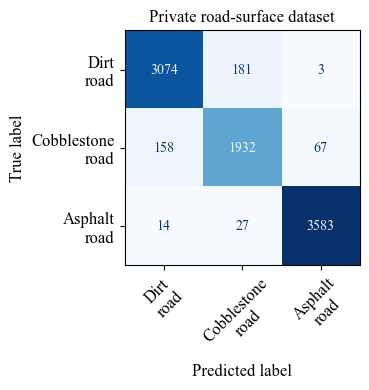

In [20]:
# Cell 6 - Ma trận nhầm lẫn

try:
    loaded_data = np.load('nested_cv_predictions_LGBM.npz')
    all_y_true = loaded_data['y_true']
    all_y_pred = loaded_data['y_pred']
    print(f"\nSuccessfully loaded {len(all_y_true)} true labels and {len(all_y_pred)} predicted labels from .npz file.")
except FileNotFoundError:
    print("Saved .npz file not found. Please run the Nested CV process first to generate it.")

class_names = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]

cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
ax.set_title("Private road-surface dataset")
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


### Cell 7 - Báo cáo phân loại

In [21]:
# Cell 7 - Báo cáo phân loại

print(classification_report(
    all_y_true,
    all_y_pred,
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))


                  precision    recall  f1-score   support

       Dirt road     0.9470    0.9435    0.9453      3258
Cobblestone road     0.9028    0.8957    0.8992      2157
    Asphalt road     0.9808    0.9887    0.9847      3624

        accuracy                         0.9502      9039
       macro avg     0.9436    0.9426    0.9431      9039
    weighted avg     0.9500    0.9502    0.9501      9039



### Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

In [6]:
# Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_LGBM = LGBMClassifier(n_estimators=50, max_depth=13, random_state=42)
final_clf_LGBM.fit(features_all, labels_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_private_LGBM.h"

try:
    c_code = export_to_c(final_clf_LGBM)
    
    with open(header_file, 'w', encoding='utf-8') as file:
        file.write(c_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19902
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 80
[LightGBM] [Info] Start training from score -1.020435
[LightGBM] [Info] Start training from score -1.432830
[LightGBM] [Info] Start training from score -0.913970
✅ Exported to 'm2cgen_private_LGBM.h'
📦 Header size: 893.15 KB (0.872 MB)


### Cell 9 - Đo thời gian huấn luyện và dự đoán

In [5]:
# Cell 9 - Đo thời gian huấn luyện và dự đoán

clf = LGBMClassifier(n_estimators=50, max_depth=13, random_state=42, verbose=-1)

# Đo thời gian huấn luyện trên toàn bộ dữ liệu
start_train = time.perf_counter()
clf.fit(features_all, labels_all)
end_train = time.perf_counter()
train_time = end_train - start_train

# Đo thời gian dự đoán (ví dụ dự đoán toàn bộ dữ liệu)
start_pred = time.perf_counter()
y_pred = clf.predict(features_all)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# In kết quả
print(f"Training time: {train_time:.4f} seconds")
print(f"Prediction time: {pred_time:.4f} seconds")

# Training time: 1.6681 seconds
# Prediction time: 0.0131 seconds


Training time: 1.6681 seconds
Prediction time: 0.0131 seconds


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 4 - Extra Trees (ET) Classifier

### Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

In [24]:
# Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

param_grid = {
    'n_estimators': range(1, 51),
    'max_depth': range(1, 21)
}

vanilla_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---\n")

grid_search_final = GridSearchCV(
    estimator=ExtraTreesClassifier(random_state=42),
    param_grid=param_grid,
    cv=vanilla_cv,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search_final.fit(features_all, labels_all)

cv_results = []
best_score = -1
best_model  = None
best_params = None
best_size   = None
model_file_path = "m2cgen_private_ET.h"

for i, params in enumerate(grid_search_final.cv_results_['params']):
    print(f"Checking params {params} ({i+1}/{len(grid_search_final.cv_results_['params'])})...")
    clf = ExtraTreesClassifier(**params, random_state=42)
    clf.fit(features_all, labels_all)
    size_mb = None
    header_tmp = 'm2cgen_ET_tmp.h'
    error_msg = ""
    try:
        c_cpp_code = export_to_c(clf)
        with open(header_tmp, 'w') as f:
            f.write(c_cpp_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
        error_msg = ""
    except Exception as e:
        error_msg = str(e)
    finally:
        if os.path.exists(header_tmp):
            os.remove(header_tmp)

    # Lưu lại tất cả các trường hợp, kể cả lỗi
    score = grid_search_final.cv_results_['mean_test_score'][i]
    cv_results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'score': score,
        'ModelSize': size_mb,
        'status': ('ok' if (size_mb is not None and size_mb <= 1.0 and not error_msg) else 'oversize' if (size_mb is not None) else f'error: {error_msg}')
    })

    # Chỉ update mô hình tốt nhất nếu hợp lệ
    if size_mb is not None and size_mb <= 1.0 and score > best_score and not error_msg:
        best_score = score
        best_model = clf
        best_params = params
        best_size = size_mb
        # Lưu best model header ra file chính thức
        with open(model_file_path, 'w') as f:
            f.write(c_cpp_code)
        print(f"  => New BEST (Accuracy={score:.4f}, size={size_mb:.3f} MB), saved to '{model_file_path}'")

print("\n===== SUMMARY =====")
if best_model is not None:
    print(f"Best Parameters: {best_params}")
    print(f"Best CV Accuracy: {best_score*100:.2f}%")
    print(f"Model header size: {best_size:.3f} MB (saved to {model_file_path})")
else:
    print("Không tìm thấy cấu hình nào đạt yêu cầu về kích thước (< 1 MB).")

df_cv = pd.DataFrame(cv_results)
df_cv.to_csv('search_results_ET.csv', index=False)
print("Chi tiết các cấu hình đã lưu vào search_results_ET.csv")



--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---

Checking params {'max_depth': 1, 'n_estimators': 1} (1/1000)...
  => New BEST (Accuracy=0.5514, size=0.001 MB), saved to 'm2cgen_private_ET.h'
Checking params {'max_depth': 1, 'n_estimators': 2} (2/1000)...
Checking params {'max_depth': 1, 'n_estimators': 3} (3/1000)...
  => New BEST (Accuracy=0.5526, size=0.001 MB), saved to 'm2cgen_private_ET.h'
Checking params {'max_depth': 1, 'n_estimators': 4} (4/1000)...
Checking params {'max_depth': 1, 'n_estimators': 5} (5/1000)...
  => New BEST (Accuracy=0.6396, size=0.002 MB), saved to 'm2cgen_private_ET.h'
Checking params {'max_depth': 1, 'n_estimators': 6} (6/1000)...
Checking params {'max_depth': 1, 'n_estimators': 7} (7/1000)...
  => New BEST (Accuracy=0.6493, size=0.003 MB), saved to 'm2cgen_private_ET.h'
Checking params {'max_depth': 1, 'n_estimators': 8} (8/1000)...
Checking params {'max_depth': 1, 'n_estimators': 9} (9/1000)...
Checking params {'max_depth': 1, 'n_e

### Cell 5 - Nested cross-validation

In [25]:
# Cell 5 - Nested cross-validation (chỉ dùng các cấu hình deployable từ search_results_ET.csv)

# ============================================================
# Đọc kết quả vanilla CV + kiểm tra kích thước model
# ============================================================
search_results_path = 'search_results_ET.csv'  # file do Cell vanilla CV tạo ra
df_search = pd.read_csv(search_results_path)

# Lọc các cấu hình thỏa điều kiện deployable: status == "ok"
df_ok = df_search[df_search['status'] == 'ok'].copy()

if df_ok.empty:
    raise RuntimeError(
        "Không có cấu hình nào có status='ok' trong search_results_ET.csv."
        "Hãy kiểm tra lại Cell vanilla CV + memory check."
    )

# Tạo danh sách cấu hình hợp lệ cho GridSearchCV
param_grid_restricted = [
    {
        'n_estimators': [int(ne)],
        'max_depth':   [int(md)]
    }
    for ne, md in zip(df_ok['n_estimators'], df_ok['max_depth'])
]

print(f"Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: {len(param_grid_restricted)}")

# ============================================================
# Nested CV với param_grid đã bị ràng buộc bởi kích thước model
# ============================================================

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_scores_acc = []
all_y_true = []
all_y_pred = []
all_test_indices = []

print("\n--- STARTING NESTED CROSS-VALIDATION (DEPLOYABLE MODELS ONLY) ---\n")

outer_fold = 1
for train_idx, test_idx in outer_cv.split(features_all, labels_all):
    print(f"📦 OUTER FOLD {outer_fold}:")

    X_train, X_test = features_all[train_idx], features_all[test_idx]
    y_train, y_test = labels_all[train_idx], labels_all[test_idx]

    print(f"  - Training data size: {len(X_train)}")
    print(f"  - Testing  data size: {len(X_test)}\n")

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=ExtraTreesClassifier(random_state=42),
        param_grid=param_grid_restricted,   # 🔒 chỉ các cấu hình size <= 1 MB
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    print(f"  🔍 Starting parameter tuning in INNER CV (10-fold)...")
    print(f"  - Number of candidate configs (deployable): {len(param_grid_restricted)}")

    grid_search.fit(X_train, y_train)

    best_model  = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score  = grid_search.best_score_

    print(f"\n  ✅ INNER CV Completed for OUTER FOLD {outer_fold}:")
    print(f"    - Best Parameters Found: {best_params}")
    print(f"    - Best Inner CV Accuracy: {best_score * 100:.2f}%\n")

    print(f"  🔍 Evaluating best model on OUTER TEST SET for Fold {outer_fold}...")

    y_pred = best_model.predict(X_test)
    acc_outer = accuracy_score(y_test, y_pred)
    
    outer_scores_acc.append(acc_outer)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_test_indices.extend(test_idx)

    print(f"  🔍 OUTER TEST SET: " f"Accuracy = {acc_outer * 100:.2f}%")
    print("-" * 60)
    outer_fold += 1

mean_acc, std_acc = np.mean(outer_scores_acc), np.std(outer_scores_acc)

print("\n--- NESTED CROSS-VALIDATION COMPLETE (DEPLOYABLE HYPER-PARAMETERS) ---")
print(f"Nested CV Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

np.savez_compressed(
    'nested_cv_predictions_ET.npz',
    y_true=np.array(all_y_true),
    y_pred=np.array(all_y_pred),
    test_indices=np.array(all_test_indices)
)
print("\ny_true, y_pred, and test_indices saved in 'nested_cv_predictions_ET.npz'.")


Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: 515

--- STARTING NESTED CROSS-VALIDATION (ROAD SURFACE, DEPLOYABLE MODELS ONLY) ---

📦 OUTER FOLD 1:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 515

  ✅ INNER CV Completed for OUTER FOLD 1:
    - Best Parameters Found: {'max_depth': 12, 'n_estimators': 11}
    - Best Inner CV Accuracy: 92.13%

  🔍 Evaluating best model on OUTER TEST SET for Fold 1...
  🔍 OUTER TEST SET: Accuracy = 91.70%
------------------------------------------------------------
📦 OUTER FOLD 2:
  - Training data size: 8135
  - Testing  data size: 904

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 515

  ✅ INNER CV Completed for OUTER FOLD 2:
    - Best Parameters Found: {'max_depth': 14, 'n_estimators': 6}
    - Best Inner CV Accuracy: 92.32%

  🔍 Evaluating best model on O

### Cell 6 - Ma trận nhầm lẫn


Successfully loaded 9039 true labels and 9039 predicted labels from .npz file.


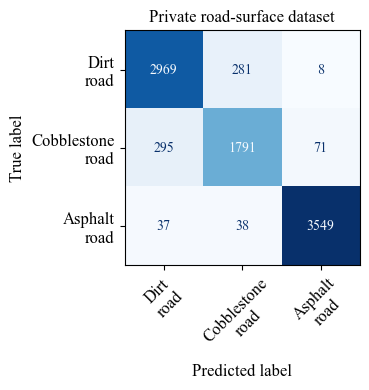

In [26]:
# Cell 6 - Ma trận nhầm lẫn

try:
    loaded_data = np.load('nested_cv_predictions_ET.npz')
    all_y_true = loaded_data['y_true']
    all_y_pred = loaded_data['y_pred']
    print(f"\nSuccessfully loaded {len(all_y_true)} true labels and {len(all_y_pred)} predicted labels from .npz file.")
except FileNotFoundError:
    print("Saved .npz file not found. Please run the Nested CV process first to generate it.")

class_names = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]

cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
ax.set_title("Private road-surface dataset")
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


### Cell 7 - Báo cáo phân loại

In [27]:
# Cell 7 - Báo cáo phân loại

print(classification_report(
    all_y_true,
    all_y_pred,
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))


                  precision    recall  f1-score   support

       Dirt road     0.8994    0.9113    0.9053      3258
Cobblestone road     0.8488    0.8303    0.8395      2157
    Asphalt road     0.9782    0.9793    0.9788      3624

        accuracy                         0.9192      9039
       macro avg     0.9088    0.9070    0.9079      9039
    weighted avg     0.9189    0.9192    0.9191      9039



### Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

In [6]:
# Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_ET = ExtraTreesClassifier(n_estimators=6, max_depth=14, random_state=42)
final_clf_ET.fit(features_all, labels_all)

# Xuất mô hình sang header C/C++ bằng m2cgen
header_file = "m2cgen_private_ET.h"

try:
    c_code = export_to_c(final_clf_ET)
    
    with open(header_file, 'w', encoding='utf-8') as file:
        file.write(c_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")


✅ Exported to 'm2cgen_private_ET.h'
📦 Header size: 936.08 KB (0.914 MB)


### Cell 9 - Đo thời gian huấn luyện và dự đoán

In [14]:
# Cell 9 - Đo thời gian huấn luyện và dự đoán

clf = ExtraTreesClassifier(n_estimators=6, max_depth=14, random_state=42)

# Đo thời gian huấn luyện trên toàn bộ dữ liệu
start_train = time.perf_counter()
clf.fit(features_all, labels_all)
end_train = time.perf_counter()
train_time = end_train - start_train

# Đo thời gian dự đoán (ví dụ dự đoán toàn bộ dữ liệu)
start_pred = time.perf_counter()
y_pred = clf.predict(features_all)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# In kết quả
print(f"Training time: {train_time:.4f} seconds")
print(f"Prediction time: {pred_time:.4f} seconds")

# Training time: 0.0459 seconds
# Prediction time: 0.0054 seconds


Training time: 0.0457 seconds
Prediction time: 0.0053 seconds


# Motobike data (.TXT)

## Cell 1 - Phân đoạn dữ liệu

In [30]:
# Cell 1 - Phân đoạn dữ liệu

root_dir_motobike = r"D:\BVHoan\Spiiras Proceedings\data_anh_Kien"

columns_motobike = [
    'Acc_X', 'Acc_Y', 'Acc_Z',
    'Gyr_X', 'Gyr_Y', 'Gyr_Z',
    'Mag_X', 'Mag_Y', 'Mag_Z',
    'Lat', 'Lon', 'Time', 'Date', 'Speed'
]

window_size_motobike = 600   # 600 samples ~ 6s @ 100Hz
stride_motobike      = 300   # 50% overlap

# Các list cửa sổ riêng cho motobike
w_dirt_road_motobike        = []
w_cobblestone_road_motobike = []
w_asphalt_road_motobike     = []

# Hàm phân đoạn file .TXT
def segment_file_motobike(file_path):
    data = pd.read_csv(file_path, names=columns_motobike)
    data['Speed'] = data['Speed'].astype(str).str.replace(';', '', regex=False).astype(float)

    windows = [
        data.iloc[i:i + window_size_motobike]
        for i in range(0, len(data), stride_motobike)
        if i + window_size_motobike <= len(data)
    ]
    return windows

# dirt_road
dir_dirt = os.path.join(root_dir_motobike, "dirt_road")
for filename in os.listdir(dir_dirt):
    if filename.endswith(".TXT"):
        file_path = os.path.join(dir_dirt, filename)
        for w in segment_file_motobike(file_path):
            w_dirt_road_motobike.append(w)

# cobblestone_road
dir_cobb = os.path.join(root_dir_motobike, "cobblestone_road")
for filename in os.listdir(dir_cobb):
    if filename.endswith(".TXT"):
        file_path = os.path.join(dir_cobb, filename)
        for w in segment_file_motobike(file_path):
            w_cobblestone_road_motobike.append(w)

# asphalt_road
dir_asph = os.path.join(root_dir_motobike, "asphalt_road")
for filename in os.listdir(dir_asph):
    if filename.endswith(".TXT"):
        file_path = os.path.join(dir_asph, filename)
        for w in segment_file_motobike(file_path):
            w_asphalt_road_motobike.append(w)

print("Motobike windows:")
print("  w_dirt_road_motobike        =", len(w_dirt_road_motobike))
print("  w_cobblestone_road_motobike =", len(w_cobblestone_road_motobike))
print("  w_asphalt_road_motobike     =", len(w_asphalt_road_motobike))
print("  Total motobike windows      =", len(w_dirt_road_motobike) + len(w_cobblestone_road_motobike) + len(w_asphalt_road_motobike))


Motobike windows:
  w_dirt_road_motobike        = 1280
  w_cobblestone_road_motobike = 166
  w_asphalt_road_motobike     = 2301
  Total motobike windows      = 3747


## Cell 2 - Gộp dữ liệu từ các lớp mặt đường khác nhau

In [31]:
# Cell 2 - Gộp dữ liệu từ các lớp mặt đường khác nhau

all_data = []
all_labels = []
raw_data_all = []

# Dirt road -> label 0
for df in w_dirt_road_motobike:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(0)

# Cobblestone road -> label 1
for df in w_cobblestone_road_motobike:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(1)

# Asphalt road -> label 2
for df in w_asphalt_road_motobike:
    all_data.append(df)
    raw_data_all.append(df)
    all_labels.append(2)

# Chuyển nhãn sang NumPy array
labels_all = np.array(all_labels)

print("Tổng số cửa sổ:", len(all_data))
print("labels_all shape:", labels_all.shape)
print("Số cửa sổ theo lớp (0,1,2):", np.bincount(labels_all))


Tổng số cửa sổ: 3747
labels_all shape: (3747,)
Số cửa sổ theo lớp (0,1,2): [1280  166 2301]


## Cell 3 - Trích xuất đặc trưng

In [32]:
# Cell 3 - Trích xuất đặc trưng

def featuresFromBuffer(at):
    feat = np.zeros(80, dtype=np.float32)

    ax = np.array(at['Acc_X'],  dtype=np.float32)
    ay = np.array(at['Acc_Y'],  dtype=np.float32)
    az = np.array(at['Acc_Z'],  dtype=np.float32)
    gx = np.array(at['Gyr_X'],  dtype=np.float32)
    gy = np.array(at['Gyr_Y'],  dtype=np.float32)
    gz = np.array(at['Gyr_Z'],  dtype=np.float32)
    sp = np.array(at['Speed'],  dtype=np.float32)

    feat[0:7] = [np.mean(i) for i in [ax, ay, az, gx, gy, gz, sp]]
    feat[7:14] = [np.std(i) for i in [ax, ay, az, gx, gy, gz, sp]]
    feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az, gx, gy, gz]]
    feat[20:26] = [np.max(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[26:32] = [np.min(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[38:44] = [np.median(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax, ay, az, gx, gy, gz]]
    feat[50:56] = [skew(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[56:62] = [kurtosis(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax, ay, az, gx, gy, gz]]
    feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax, ay, az, gx, gy, gz]]
    feat[74:80] = [acf(i, nlags=1)[1] for i in [ax, ay, az, gx, gy, gz]]
    
    return feat

# Trích xuất đặc trưng cho toàn bộ dữ liệu
features_all = np.array([featuresFromBuffer(win) for win in raw_data_all], dtype=np.float32)

print("features_all shape:", features_all.shape)


features_all shape: (3747, 80)


## Cell 4 - Vanilla cross-validation + kiểm tra kích thước header

In [33]:
# Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

param_grid = {
    'n_estimators': range(1, 51),
    'max_depth': range(1, 11)
}

vanilla_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---\n")

grid_search_final = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=vanilla_cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)
grid_search_final.fit(features_all, labels_all)

cv_results = []
best_score = -1
best_model  = None
best_params = None
best_size   = None
model_file_path = "micromlgen_private_XGB.h"

for i, params in enumerate(grid_search_final.cv_results_['params']):
    print(f"Checking params {params} ({i+1}/{len(grid_search_final.cv_results_['params'])})...")
    clf = XGBClassifier(**params, random_state=42)
    clf.fit(features_all, labels_all)

    temp_file_path = None
    size_mb = None
    header_tmp = 'micromlgen_XGB_tmp.h'
    error_msg = ""
    try:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False, encoding='utf-8') as tmp:
            temp_file_path = tmp.name
            pass
        c_cpp_code = port(clf, tmp_file=temp_file_path)
        with open(header_tmp, 'w') as f:
            f.write(c_cpp_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024*1024)
        error_msg = ""
    except Exception as e:
        error_msg = str(e)
    finally:
        if temp_file_path and os.path.exists(temp_file_path):
            os.remove(temp_file_path)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)

    # Lưu lại tất cả các trường hợp, kể cả lỗi
    score = grid_search_final.cv_results_['mean_test_score'][i]
    cv_results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'score': score,
        'ModelSize': size_mb,
        'status': ('ok' if (size_mb is not None and size_mb <= 1.0 and not error_msg) else 'oversize' if (size_mb is not None) else f'error: {error_msg}')
    })

    # Chỉ update mô hình tốt nhất nếu hợp lệ
    if size_mb is not None and size_mb <= 1.0 and score > best_score and not error_msg:
        best_score = score
        best_model = clf
        best_params = params
        best_size = size_mb
        # Lưu best model header ra file chính thức
        with open(model_file_path, 'w') as f:
            f.write(c_cpp_code)
        print(f"  => New BEST (F1-score={score:.4f}, size={size_mb:.3f} MB), saved to '{model_file_path}'")

print("\n===== SUMMARY =====")
if best_model is not None:
    print(f"Best Parameters: {best_params}")
    print(f"Best CV F1-score: {best_score*100:.2f}%")
    print(f"Model header size: {best_size:.3f} MB (saved to {model_file_path})")
else:
    print("Không tìm thấy cấu hình nào đạt yêu cầu về kích thước (< 1 MB).")

df_cv = pd.DataFrame(cv_results)
df_cv.to_csv('search_results_XGB.csv', index=False)
print("Chi tiết các cấu hình đã lưu vào search_results_XGB.csv")



--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---

Checking params {'max_depth': 1, 'n_estimators': 1} (1/500)...
  => New BEST (F1-score=0.9884, size=0.002 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 2} (2/500)...
  => New BEST (F1-score=0.9906, size=0.003 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 3} (3/500)...
  => New BEST (F1-score=0.9976, size=0.003 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 4} (4/500)...
Checking params {'max_depth': 1, 'n_estimators': 5} (5/500)...
Checking params {'max_depth': 1, 'n_estimators': 6} (6/500)...
Checking params {'max_depth': 1, 'n_estimators': 7} (7/500)...
Checking params {'max_depth': 1, 'n_estimators': 8} (8/500)...
Checking params {'max_depth': 1, 'n_estimators': 9} (9/500)...
Checking params {'max_depth': 1, 'n_estimators': 10} (10/500)...
Checking params {'max_depth': 1, 'n_estimator

## Cell 5 - Nested cross-validation

In [36]:
# Cell 5 - Nested cross-validation (chỉ dùng các cấu hình deployable từ search_results_XGB.csv)

# ============================================================
# Đọc kết quả vanilla CV + kiểm tra kích thước model
# ============================================================
search_results_path = 'search_results_XGB.csv'  # file do Cell vanilla CV tạo ra
df_search = pd.read_csv(search_results_path)

# Lọc các cấu hình thỏa điều kiện deployable: status == "ok"
df_ok = df_search[df_search['status'] == 'ok'].copy()

if df_ok.empty:
    raise RuntimeError(
        "Không có cấu hình nào có status='ok' trong search_results_XGB.csv."
        "Hãy kiểm tra lại Cell vanilla CV + memory check."
    )

# Tạo danh sách cấu hình hợp lệ cho GridSearchCV
param_grid_restricted = [
    {
        'n_estimators': [int(ne)],
        'max_depth':   [int(md)]
    }
    for ne, md in zip(df_ok['n_estimators'], df_ok['max_depth'])
]

print(f"Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: {len(param_grid_restricted)}")

# ============================================================
# Nested CV với param_grid đã bị ràng buộc bởi kích thước model
# ============================================================

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_scores_acc = []
outer_scores_f1  = []
all_y_true = []
all_y_pred = []
all_test_indices = []

print("\n--- STARTING NESTED CROSS-VALIDATION (DEPLOYABLE MODELS ONLY) ---\n")

outer_fold = 1
for train_idx, test_idx in outer_cv.split(features_all, labels_all):
    print(f"📦 OUTER FOLD {outer_fold}:")

    X_train, X_test = features_all[train_idx], features_all[test_idx]
    y_train, y_test = labels_all[train_idx], labels_all[test_idx]

    print(f"  - Training data size: {len(X_train)}")
    print(f"  - Testing  data size: {len(X_test)}\n")

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=XGBClassifier(random_state=42),
        param_grid=param_grid_restricted,   # 🔒 chỉ các cấu hình size <= 1 MB
        cv=inner_cv,
        scoring='f1_macro',
        n_jobs=-1
    )

    print(f"  🔍 Starting parameter tuning in INNER CV (10-fold)...")
    print(f"  - Number of candidate configs (deployable): {len(param_grid_restricted)}")

    grid_search.fit(X_train, y_train)

    best_model  = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score  = grid_search.best_score_

    print(f"\n  ✅ INNER CV Completed for OUTER FOLD {outer_fold}:")
    print(f"    - Best Parameters Found: {best_params}")
    print(f"    - Best Inner CV F1-score: {best_score * 100:.2f}%\n")

    print(f"  🔍 Evaluating best model on OUTER TEST SET for Fold {outer_fold}...")

    y_pred = best_model.predict(X_test)
    acc_outer = accuracy_score(y_test, y_pred)
    f1_score_outer = f1_score(y_test, y_pred, average='macro')

    outer_scores_acc.append(acc_outer)
    outer_scores_f1.append(f1_score_outer)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_test_indices.extend(test_idx)

    print(f"  🔍 OUTER TEST SET: " f"Accuracy = {acc_outer * 100:.2f}% | " f"F1-score = {f1_score_outer * 100:.2f}%")
    print("-" * 60)
    outer_fold += 1

mean_acc, std_acc = np.mean(outer_scores_acc), np.std(outer_scores_acc)
mean_f1, std_f1   = np.mean(outer_scores_f1), np.std(outer_scores_f1)

print("\n--- NESTED CROSS-VALIDATION COMPLETE (DEPLOYABLE HYPER-PARAMETERS) ---")
print(f"Nested CV Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Nested CV F1-score: {mean_f1  * 100:.2f}% ± {std_f1  * 100:.2f}%")

np.savez_compressed(
    'nested_cv_predictions_XGB.npz',
    y_true=np.array(all_y_true),
    y_pred=np.array(all_y_pred),
    test_indices=np.array(all_test_indices)
)
print("\ny_true, y_pred, and test_indices saved in 'nested_cv_predictions_XGB.npz'.")


Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: 500

--- STARTING NESTED CROSS-VALIDATION (ROAD SURFACE, DEPLOYABLE MODELS ONLY) ---

📦 OUTER FOLD 1:
  - Training data size: 3372
  - Testing  data size: 375

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 500

  ✅ INNER CV Completed for OUTER FOLD 1:
    - Best Parameters Found: {'max_depth': 1, 'n_estimators': 11}
    - Best Inner CV F1-score: 100.00%

  🔍 Evaluating best model on OUTER TEST SET for Fold 1...
  🔍 OUTER TEST SET: Accuracy = 100.00% | F1-score = 100.00%
------------------------------------------------------------
📦 OUTER FOLD 2:
  - Training data size: 3372
  - Testing  data size: 375

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 500

  ✅ INNER CV Completed for OUTER FOLD 2:
    - Best Parameters Found: {'max_depth': 1, 'n_estimators': 16}
    - Best Inner CV F1-score: 100.00%

  🔍 Eva

## Cell 6 - Ma trận nhầm lẫn


Successfully loaded 3747 true labels and 3747 predicted labels from .npz file.


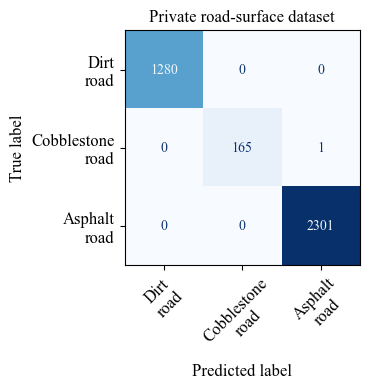

In [37]:
# Cell 6 - Ma trận nhầm lẫn

try:
    loaded_data = np.load('nested_cv_predictions_XGB.npz')
    all_y_true = loaded_data['y_true']
    all_y_pred = loaded_data['y_pred']
    print(f"\nSuccessfully loaded {len(all_y_true)} true labels and {len(all_y_pred)} predicted labels from .npz file.")
except FileNotFoundError:
    print("Saved .npz file not found. Please run the Nested CV process first to generate it.")

class_names = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]

cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
ax.set_title("Private road-surface dataset")
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 7 - Báo cáo phân loại

In [38]:
# Cell 7 - Báo cáo phân loại

print(classification_report(
    all_y_true,
    all_y_pred,
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))


                  precision    recall  f1-score   support

       Dirt road     1.0000    1.0000    1.0000      1280
Cobblestone road     1.0000    0.9940    0.9970       166
    Asphalt road     0.9996    1.0000    0.9998      2301

        accuracy                         0.9997      3747
       macro avg     0.9999    0.9980    0.9989      3747
    weighted avg     0.9997    0.9997    0.9997      3747



## Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

In [40]:
# Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_XGB = XGBClassifier(n_estimators=18, max_depth=1, random_state=42)
final_clf_XGB.fit(features_all, labels_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_private_XGB.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_XGB, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_private_XGB.h'
📦 Header size: 15.86 KB (0.015 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmp_6wggp3v.json


# Car data (.CSV)

## Cell 1 - Phân đoạn dữ liệu

In [41]:

# Đường dẫn tới file CSV
csv_path_car = r"D:\BVHoan\Spiiras Proceedings\data_thay_Cong\data.csv"
# Đọc dữ liệu
df_car = pd.read_csv(csv_path_car)

# Chuẩn hoá cột: Time,Lat,Lon,Alt,Speed,Sats,Ax,Ay,Az,Gx,Gy,Gz,Mx,My,Mz,ROADSURFACE
df_car = df_car.rename(columns={
    'Ax': 'Acc_X',
    'Ay': 'Acc_Y',
    'Az': 'Acc_Z',
    'Gx': 'Gyr_X',
    'Gy': 'Gyr_Y',
    'Gz': 'Gyr_Z',
    'Mx': 'Mag_X',
    'My': 'Mag_Y',
    'Mz': 'Mag_Z',
    'Speed': 'Speed',
    'ROADSURFACE': 'Label'
})

# Bỏ các mẫu dừng (Label = -1)
df_car = df_car[df_car['Label'] != -1].reset_index(drop=True)

window_size_car = 300   # 6s @ 50Hz
stride_car      = 150

# Hàm phân đoạn car
def segment_df_car(data):
    windows = [
        data.iloc[i:i + window_size_car]
        for i in range(0, len(data), stride_car)
        if i + window_size_car <= len(data)
    ]
    return windows

# Tách theo lớp
df_dirt_car = df_car[df_car['Label'] == 0].reset_index(drop=True)
df_cobb_car = df_car[df_car['Label'] == 1].reset_index(drop=True)
df_asph_car = df_car[df_car['Label'] == 2].reset_index(drop=True)

# Các list cửa sổ riêng cho car
w_dirt_road_car        = segment_df_car(df_dirt_car)
w_cobblestone_road_car = segment_df_car(df_cobb_car)
w_asphalt_road_car     = segment_df_car(df_asph_car)

print("\nCar windows:")
print("  w_dirt_road_car        =", len(w_dirt_road_car))
print("  w_cobblestone_road_car =", len(w_cobblestone_road_car))
print("  w_asphalt_road_car     =", len(w_asphalt_road_car))
print("  Total car windows      =", 
      len(w_dirt_road_car) + len(w_cobblestone_road_car) + len(w_asphalt_road_car))



Car windows:
  w_dirt_road_car        = 1978
  w_cobblestone_road_car = 1991
  w_asphalt_road_car     = 1323
  Total car windows      = 5292


## Cell 2 - Gộp dữ liệu từ các lớp mặt đường khác nhau

In [42]:
# Cell 2 - Gộp dữ liệu từ các lớp mặt đường khác nhau

all_data = []
all_labels = []
raw_data_all = []

# Dirt road -> label 0
for df_win in w_dirt_road_car:
    all_data.append(df_win)
    raw_data_all.append(df_win)
    all_labels.append(0)

# Cobblestone road -> label 1
for df_win in w_cobblestone_road_car:
    all_data.append(df_win)
    raw_data_all.append(df_win)
    all_labels.append(1)

# Asphalt road -> label 2
for df_win in w_asphalt_road_car:
    all_data.append(df_win)
    raw_data_all.append(df_win)
    all_labels.append(2)

# Chuyển nhãn sang NumPy array
labels_all = np.array(all_labels)

print("Tổng số cửa sổ:", len(all_data))
print("labels_all shape:", labels_all.shape)
print("Số cửa sổ theo lớp (0,1,2):", np.bincount(labels_all))


Tổng số cửa sổ: 5292
labels_all shape: (5292,)
Số cửa sổ theo lớp (0,1,2): [1978 1991 1323]


## Cell 3 - Trích xuất đặc trưng

In [43]:
# Cell 3 - Trích xuất đặc trưng

def featuresFromBuffer(at):
    feat = np.zeros(80, dtype=np.float32)

    ax = np.array(at['Acc_X'],  dtype=np.float32)
    ay = np.array(at['Acc_Y'],  dtype=np.float32)
    az = np.array(at['Acc_Z'],  dtype=np.float32)
    gx = np.array(at['Gyr_X'],  dtype=np.float32)
    gy = np.array(at['Gyr_Y'],  dtype=np.float32)
    gz = np.array(at['Gyr_Z'],  dtype=np.float32)
    sp = np.array(at['Speed'],  dtype=np.float32)

    feat[0:7] = [np.mean(i) for i in [ax, ay, az, gx, gy, gz, sp]]
    feat[7:14] = [np.std(i) for i in [ax, ay, az, gx, gy, gz, sp]]
    feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az, gx, gy, gz]]
    feat[20:26] = [np.max(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[26:32] = [np.min(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[38:44] = [np.median(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax, ay, az, gx, gy, gz]]
    feat[50:56] = [skew(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[56:62] = [kurtosis(i) for i in [ax, ay, az, gx, gy, gz]]
    feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax, ay, az, gx, gy, gz]]
    feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax, ay, az, gx, gy, gz]]
    feat[74:80] = [acf(i, nlags=1)[1] for i in [ax, ay, az, gx, gy, gz]]
    
    return feat

# Trích xuất đặc trưng cho toàn bộ dữ liệu
features_all = np.array([featuresFromBuffer(win) for win in raw_data_all], dtype=np.float32)

print("features_all shape:", features_all.shape)


features_all shape: (5292, 80)


## Cell 4 - Vanilla cross-validation + kiểm tra kích thước header

In [44]:
# Cell 4 - Vanilla cross-validation + kiểm tra kích thước mô hình

param_grid = {
    'n_estimators': range(1, 51),
    'max_depth': range(1, 11)
}

vanilla_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---\n")

grid_search_final = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=vanilla_cv,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)
grid_search_final.fit(features_all, labels_all)

cv_results = []
best_score = -1
best_model  = None
best_params = None
best_size   = None
model_file_path = "micromlgen_private_XGB.h"

for i, params in enumerate(grid_search_final.cv_results_['params']):
    print(f"Checking params {params} ({i+1}/{len(grid_search_final.cv_results_['params'])})...")
    clf = XGBClassifier(**params, random_state=42)
    clf.fit(features_all, labels_all)

    temp_file_path = None
    size_mb = None
    header_tmp = 'micromlgen_XGB_tmp.h'
    error_msg = ""
    try:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False, encoding='utf-8') as tmp:
            temp_file_path = tmp.name
            pass
        c_cpp_code = port(clf, tmp_file=temp_file_path)
        with open(header_tmp, 'w') as f:
            f.write(c_cpp_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024*1024)
        error_msg = ""
    except Exception as e:
        error_msg = str(e)
    finally:
        if temp_file_path and os.path.exists(temp_file_path):
            os.remove(temp_file_path)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)

    # Lưu lại tất cả các trường hợp, kể cả lỗi
    score = grid_search_final.cv_results_['mean_test_score'][i]
    cv_results.append({
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'score': score,
        'ModelSize': size_mb,
        'status': ('ok' if (size_mb is not None and size_mb <= 1.0 and not error_msg) else 'oversize' if (size_mb is not None) else f'error: {error_msg}')
    })

    # Chỉ update mô hình tốt nhất nếu hợp lệ
    if size_mb is not None and size_mb <= 1.0 and score > best_score and not error_msg:
        best_score = score
        best_model = clf
        best_params = params
        best_size = size_mb
        # Lưu best model header ra file chính thức
        with open(model_file_path, 'w') as f:
            f.write(c_cpp_code)
        print(f"  => New BEST (F1-score={score:.4f}, size={size_mb:.3f} MB), saved to '{model_file_path}'")

print("\n===== SUMMARY =====")
if best_model is not None:
    print(f"Best Parameters: {best_params}")
    print(f"Best CV F1-score: {best_score*100:.2f}%")
    print(f"Model header size: {best_size:.3f} MB (saved to {model_file_path})")
else:
    print("Không tìm thấy cấu hình nào đạt yêu cầu về kích thước (< 1 MB).")

df_cv = pd.DataFrame(cv_results)
df_cv.to_csv('search_results_XGB.csv', index=False)
print("Chi tiết các cấu hình đã lưu vào search_results_XGB.csv")



--- STARTING VANILLA CROSS-VALIDATION + MEMORY CHECK (header .h) ---



Checking params {'max_depth': 1, 'n_estimators': 1} (1/500)...
  => New BEST (F1-score=0.7884, size=0.002 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 2} (2/500)...
  => New BEST (F1-score=0.7981, size=0.003 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 3} (3/500)...
Checking params {'max_depth': 1, 'n_estimators': 4} (4/500)...
  => New BEST (F1-score=0.8021, size=0.004 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 5} (5/500)...
  => New BEST (F1-score=0.8130, size=0.005 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 6} (6/500)...
  => New BEST (F1-score=0.8177, size=0.006 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 7} (7/500)...
  => New BEST (F1-score=0.8221, size=0.007 MB), saved to 'micromlgen_private_XGB.h'
Checking params {'max_depth': 1, 'n_estimators': 8} (8/

## Cell 5 - Nested cross-validation

In [45]:
# Cell 5 - Nested cross-validation (chỉ dùng các cấu hình deployable từ search_results_XGB.csv)

# ============================================================
# Đọc kết quả vanilla CV + kiểm tra kích thước model
# ============================================================
search_results_path = 'search_results_XGB.csv'  # file do Cell vanilla CV tạo ra
df_search = pd.read_csv(search_results_path)

# Lọc các cấu hình thỏa điều kiện deployable: status == "ok"
df_ok = df_search[df_search['status'] == 'ok'].copy()

if df_ok.empty:
    raise RuntimeError(
        "Không có cấu hình nào có status='ok' trong search_results_XGB.csv."
        "Hãy kiểm tra lại Cell vanilla CV + memory check."
    )

# Tạo danh sách cấu hình hợp lệ cho GridSearchCV
param_grid_restricted = [
    {
        'n_estimators': [int(ne)],
        'max_depth':   [int(md)]
    }
    for ne, md in zip(df_ok['n_estimators'], df_ok['max_depth'])
]

print(f"Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: {len(param_grid_restricted)}")

# ============================================================
# Nested CV với param_grid đã bị ràng buộc bởi kích thước model
# ============================================================

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_scores_acc = []
outer_scores_f1  = []
all_y_true = []
all_y_pred = []
all_test_indices = []

print("\n--- STARTING NESTED CROSS-VALIDATION (DEPLOYABLE MODELS ONLY) ---\n")

outer_fold = 1
for train_idx, test_idx in outer_cv.split(features_all, labels_all):
    print(f"📦 OUTER FOLD {outer_fold}:")

    X_train, X_test = features_all[train_idx], features_all[test_idx]
    y_train, y_test = labels_all[train_idx], labels_all[test_idx]

    print(f"  - Training data size: {len(X_train)}")
    print(f"  - Testing  data size: {len(X_test)}\n")

    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=XGBClassifier(random_state=42),
        param_grid=param_grid_restricted,   # 🔒 chỉ các cấu hình size <= 1 MB
        cv=inner_cv,
        scoring='f1_macro',
        n_jobs=-1
    )

    print(f"  🔍 Starting parameter tuning in INNER CV (10-fold)...")
    print(f"  - Number of candidate configs (deployable): {len(param_grid_restricted)}")

    grid_search.fit(X_train, y_train)

    best_model  = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score  = grid_search.best_score_

    print(f"\n  ✅ INNER CV Completed for OUTER FOLD {outer_fold}:")
    print(f"    - Best Parameters Found: {best_params}")
    print(f"    - Best Inner CV F1-score: {best_score * 100:.2f}%\n")

    print(f"  🔍 Evaluating best model on OUTER TEST SET for Fold {outer_fold}...")

    y_pred = best_model.predict(X_test)
    acc_outer = accuracy_score(y_test, y_pred)
    f1_score_outer = f1_score(y_test, y_pred, average='macro')

    outer_scores_acc.append(acc_outer)
    outer_scores_f1.append(f1_score_outer)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_test_indices.extend(test_idx)

    print(f"  🔍 OUTER TEST SET: " f"Accuracy = {acc_outer * 100:.2f}% | " f"F1-score = {f1_score_outer * 100:.2f}%")
    print("-" * 60)
    outer_fold += 1

mean_acc, std_acc = np.mean(outer_scores_acc), np.std(outer_scores_acc)
mean_f1, std_f1   = np.mean(outer_scores_f1), np.std(outer_scores_f1)

print("\n--- NESTED CROSS-VALIDATION COMPLETE (DEPLOYABLE HYPER-PARAMETERS) ---")
print(f"Nested CV Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")
print(f"Nested CV F1-score: {mean_f1  * 100:.2f}% ± {std_f1  * 100:.2f}%")

np.savez_compressed(
    'nested_cv_predictions_XGB.npz',
    y_true=np.array(all_y_true),
    y_pred=np.array(all_y_pred),
    test_indices=np.array(all_test_indices)
)
print("\ny_true, y_pred, and test_indices saved in 'nested_cv_predictions_XGB.npz'.")


Số cấu hình hyper-parameter deployable (status='ok') sẽ dùng cho nested CV: 344

--- STARTING NESTED CROSS-VALIDATION (ROAD SURFACE, DEPLOYABLE MODELS ONLY) ---

📦 OUTER FOLD 1:
  - Training data size: 4762
  - Testing  data size: 530

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 344

  ✅ INNER CV Completed for OUTER FOLD 1:
    - Best Parameters Found: {'max_depth': 6, 'n_estimators': 38}
    - Best Inner CV F1-score: 92.20%

  🔍 Evaluating best model on OUTER TEST SET for Fold 1...
  🔍 OUTER TEST SET: Accuracy = 91.70% | F1-score = 92.06%
------------------------------------------------------------
📦 OUTER FOLD 2:
  - Training data size: 4762
  - Testing  data size: 530

  🔍 Starting parameter tuning in INNER CV (10-fold)...
  - Number of candidate configs (deployable): 344

  ✅ INNER CV Completed for OUTER FOLD 2:
    - Best Parameters Found: {'max_depth': 6, 'n_estimators': 39}
    - Best Inner CV F1-score: 92.08%

  🔍 Evaluat

## Cell 6 - Ma trận nhầm lẫn


Successfully loaded 5292 true labels and 5292 predicted labels from .npz file.


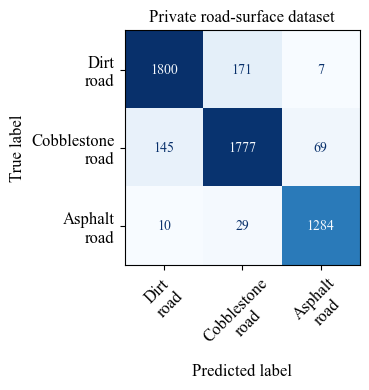

In [46]:
# Cell 6 - Ma trận nhầm lẫn

try:
    loaded_data = np.load('nested_cv_predictions_XGB.npz')
    all_y_true = loaded_data['y_true']
    all_y_pred = loaded_data['y_pred']
    print(f"\nSuccessfully loaded {len(all_y_true)} true labels and {len(all_y_pred)} predicted labels from .npz file.")
except FileNotFoundError:
    print("Saved .npz file not found. Please run the Nested CV process first to generate it.")

class_names = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]

cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
ax.set_title("Private road-surface dataset")
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 7 - Báo cáo phân loại

In [47]:
# Cell 7 - Báo cáo phân loại

print(classification_report(
    all_y_true,
    all_y_pred,
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))


                  precision    recall  f1-score   support

       Dirt road     0.9207    0.9100    0.9153      1978
Cobblestone road     0.8988    0.8925    0.8957      1991
    Asphalt road     0.9441    0.9705    0.9571      1323

        accuracy                         0.9186      5292
       macro avg     0.9212    0.9243    0.9227      5292
    weighted avg     0.9183    0.9186    0.9184      5292



## Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

In [49]:
# Cell 8 - Huấn luyện trên toàn bộ dữ liệu và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_XGB = XGBClassifier(n_estimators=34, max_depth=6, random_state=42)
final_clf_XGB.fit(features_all, labels_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_private_XGB.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_XGB, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_private_XGB.h'
📦 Header size: 898.40 KB (0.877 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmpzv5mb8ko.json
